<a href="https://colab.research.google.com/github/ddopp4877/single-cell-tuning/blob/main/test_cell_with_syns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade numpy==1.24.4 pandas==2.2.2 scipy==1.11.3> /dev/null 2>&1

import os
os.kill(os.getpid(), 9)#restart so the above packages can be used

In [1]:
# If running in Colab
!pip install --upgrade pip2 > /dev/null 2>&1
!pip install --quiet allensdk neuron > /dev/null 2>&1
!git clone -b release_candidate https://github.com/V-Marco/ACT.git > /dev/null 2>&1

In [2]:
!pip install --quiet allensdk neuron

In [1]:
# Mouse L2/3 SST (Som) cell
# http://celltypes.brain-map.org/mouse/experiment/electrophysiology/476686112
specimen_id = 476686112
model_type = 'perisomatic'#or 'all active'
work_dir = 'OriginalFromAllenDB'

In [2]:
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("ACT")
from act.passive import ACTPassiveModule

In [3]:
from allensdk.api.queries.biophysical_api import BiophysicalApi
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils

In [4]:
#get the model id

bp = BiophysicalApi()#using AllenDB's API
models = bp.get_neuronal_models(specimen_id)

for model in models:
  if model_type in model['name'].lower():
    print(f"model id = {model['id']}\n")
    model_id = model['id']
models

model id = 477878284



[{'id': 477878284,
  'name': 'Biophysical - perisomatic_Sst-IRES-Cre;Ai14-188740.03.02.01',
  'neuron_reconstruction_id': 491119369,
  'neuronal_model_template_id': 329230710,
  'specimen_id': 476686112},
 {'id': 497232660,
  'name': 'Biophysical - all active_Sst-IRES-Cre;Ai14-188740.03.02.01',
  'neuron_reconstruction_id': 491119369,
  'neuronal_model_template_id': 491455321,
  'specimen_id': 476686112}]

In [5]:
# Download the cell
bp.cache_stimulus = False # Change to False to not download the large stimulus NWB file
bp.cache_data(model_id, working_directory = work_dir )
os.chdir(work_dir)

2025-05-25 18:32:10,416 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210401
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210401
2025-05-25 18:32:10,875 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210404
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210404
2025-05-25 18:32:11,010 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337293
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337293
2025-05-25 18:32:11,149 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_fi

In [8]:
import requests
path = "https://raw.githubusercontent.com/yzerlaut/pv-sst-dendrites/main/detailed_model/mechanisms"
filenames = ['NMDAIN.mod','vecstim.mod','cpampain.mod', 'gabaain.mod']

for filename in filenames:

  url = os.path.join(path,filename)
  response = requests.get(url)

  if response.status_code == 200:
      with open(os.path.join('modfiles',filename), 'w') as f:#assuming you are in work_dir and the mechanisms are in a folder called 'modflies'
          f.write(response.text)
  else:
      print(f"Failed to download file: {response.status_code}")

In [6]:
# Compile the modfiles

!nrnivmodl modfiles > /dev/null 2>&1

In [7]:
import sys, os
from functools import wraps

def suppress_output(fn):
    @wraps(fn)
    def wrapper(*args, **kwargs):
        devnull = open(os.devnull, 'w')
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout = sys.stderr = devnull
        try:
            return fn(*args, **kwargs)
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr
            devnull.close()
    return wrapper

In [8]:
@suppress_output
def build_cell(soma_diam_multiplier = 1,using_hoc=False,hoc_filename=None,cell_name=None):

    if using_hoc:
      from neuron import h
      h.load_file(hoc_filename)
      return getattr(h, cell_name)()
    # Create the h object
    description = Config().load('manifest.json')
    utils = Utils(description)
    h = utils.h
    # Convert all "value" attributes to floats
    for dict in utils.description.data['genome']:
        for key, value in dict.items():
            if key == 'value': dict[key] = float(value)
    # Configure morphology
    morphology_path = description.manifest.get_path('MORPHOLOGY')
    utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))
    utils.load_cell_parameters()
    # To match PP
    h.soma[0].diam = h.soma[0].diam * soma_diam_multiplier

    return h

In [9]:
from neuron import h
h.load_file("stdrun.hoc")  # Required to use h.run()



1.0

In [13]:
def run(h):

  nmda = h.CPGLUIN(0.5,h.dend[32])
  vecstim = h.VecStim()
  times = h.Vector([500])
  vecstim.play(times)
  rec_times = h.Vector()
  nc = h.NetCon(vecstim, None)  # No target, just record events
  nc.record(rec_times)
  nmdaNetCON = h.NetCon(vecstim,nmda)
  nmdaNetCON.weight[0] = 0.0001

  v = h.Vector().record(h.dend[32](0.5)._ref_v)
  i  = h.Vector().record(nmda._ref_iglu)
  h.finitialize()
  h.dt=0.025
  h.tstop = 1000
  h.run()
  return v,rec_times,times,i

In [14]:
h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v,nc,times,i = run(h)

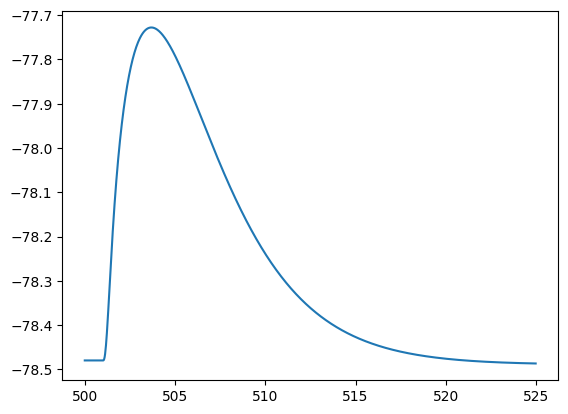

In [16]:
start, end = 20000,21000

V = v.as_numpy()
times = np.arange(0,1000.025,0.025)
plt.plot(times[start:end],V[start:end])

#Automated

In [150]:
def create_syns(h,syn_point_proc, seg,dend_sec_no, nsyn):
  syns =  [syn_point_proc(seg, h.dend[int(dend_sec_no)]) for i in range(nsyn)]
  return syns

In [151]:
def insert_syns(h,sim_params,name):

  nsyns = sim_params['nsyn_exc']

  point_proc_name = f"{name}_point_proc"

  seg = sim_params[f"{name}_seg"]
  sec = sim_params[f"{name}_sec"]

  syns = create_syns(h,sim_params[point_proc_name],seg,sec,sim_params['nsyn_exc'])
  vec_stims = [h.VecStim() for i in range(nsyns)]
  event_times_vectors = [h.Vector(sim_params["event_times"][i]) for i in range(nsyns)]

  ncs = []
  for i in range(nsyns):
    vec_stims[i].play(event_times_vectors[i])
    nc = h.NetCon(vec_stims[i],syns[i])
    nc.weight[0] = sim_params[f"{name}_weight"]
    ncs.append(nc)

  return_dict = {"nsyns": nsyns,
                  "syns": syns,
                  "vec_stims": vec_stims,
                  "event_times_vectors":event_times_vectors,
                  "ncs":ncs}

  return return_dict


In [570]:

  def run(h,sim_params):

    nsyns = sim_params['nsyn_exc']

    ampa_return_dict = insert_syns(h,sim_params,'ampa')
    nmda_return_dict = insert_syns(h,sim_params,'nmda')

    # v = h.Vector().record(h.dend[33](0.67)._ref_v)
    v = h.Vector().record(h.soma[0](0.5)._ref_v)
    h.finitialize()
    h.dt=0.025
    h.tstop = 1000
    h.run()

    return v

In [474]:
5*0.025

0.125

In [475]:
nsyn_exc = int(40 *.04 * 2)
sim_params = {"event_times":[[400], [400.5],[401]],
              "ampa_weight": 0.0001,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.5,
              "ampa_sec": 32,

              "nmda_weight": 0.005,
              "nmda_point_proc": h.NMDAIN,
              "nmda_seg": 0.5,
              "nmda_sec": 32,

              "nsyn_exc":3
              }

In [476]:
h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v= run(h,sim_params)
# v = v.as_numpy()

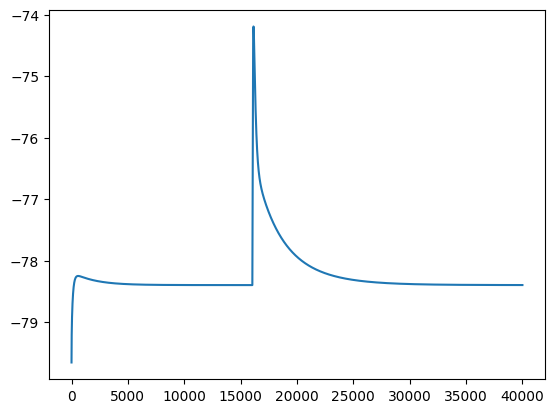

In [477]:
plt.plot(v)

#proximal

real

In [457]:
nsyn_exc = int(40 *.04 * 2)
sim_params = {"event_times":[[400], [400.5],[401]],
              "ampa_weight": 0.0001,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.5,
              "ampa_sec": 32,

              "nmda_weight": 0.005,
              "nmda_point_proc": h.NMDAIN,
              "nmda_seg": 0.5,
              "nmda_sec": 32,

              "nsyn_exc":3
              }

In [458]:
h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v= run(h,sim_params)
v = v.as_numpy()

tstart = sim_params["event_times"][0][0]-500
tstop = tstart +50
vrest = np.mean(v[tstart:tstop])
corrected_v = v-vrest
corrected_v = np.array(corrected_v)


Text(0.5, 1.0, 'Proximal Real')

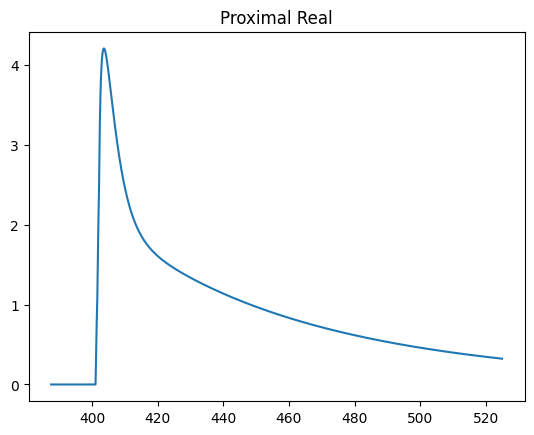

In [463]:
start, end = int(sim_params["event_times"][0][0]/0.025 - 500), int(sim_params["event_times"][0][0]/0.025 + 5000)
real = corrected_v[start:end]
times = np.arange(0,1000.025,0.025)
t = times[start:end]
plt.plot(t,real)
plt.title("Proximal Real")

expected

In [478]:
nsyn_exc = int(40 *.04 * 2)
sim_params = {"event_times":[[400]],
              "ampa_weight": 0.0001,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.5,
              "ampa_sec": 32,

              "nmda_weight": 0.005,
              "nmda_point_proc": h.NMDAIN,
              "nmda_seg": 0.5,
              "nmda_sec": 32,

              "nsyn_exc":1
              }

In [479]:
h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v= run(h,sim_params)
v = v.as_numpy()



In [480]:
tstart = sim_params["event_times"][0][0]-500
tstop = tstart +4
vrest = np.mean(v[tstart:tstop])
corrected_v = v-vrest#use the same vrest as for real
corrected_v = np.array(corrected_v)

Text(0.5, 1.0, 'Expected')

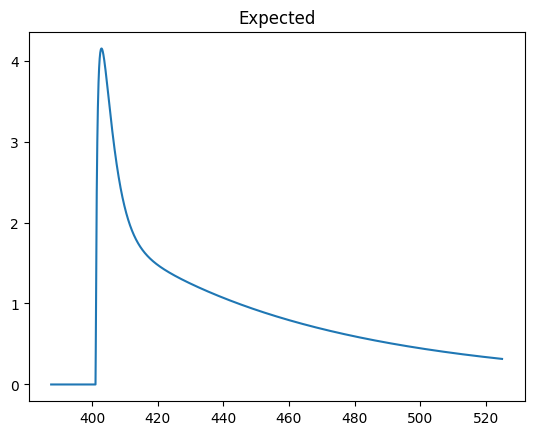

In [481]:
start, end = int(sim_params["event_times"][0][0]/0.025 - 500), int(sim_params["event_times"][0][0]/0.025 + 5000)
expected = corrected_v[start:end]*3
times = np.arange(0,1000.025,0.025)
t = times[start:end]
plt.plot(t,expected)
plt.title("Expected")

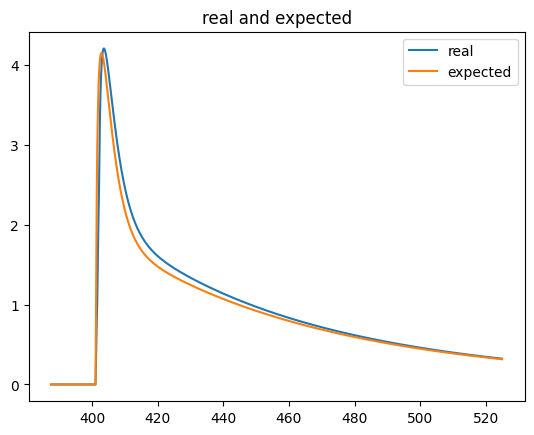

In [483]:
plt.plot(t,real,label="real")
plt.plot(t,expected,label="expected")
plt.legend()
plt.title("real and expected")
plt.show()

#Distal

In [508]:
nsyn_exc = int(40 *.04 * 2)
sim_params = {"event_times":[[400], [400.5],[401]],
              "ampa_weight": 0.0001,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.67,
              "ampa_sec": 33,

              "nmda_weight": 0.005,
              "nmda_point_proc": h.NMDAIN,
              "nmda_seg": 0.67,
              "nmda_sec": 33,

              "nsyn_exc":3
              }

In [509]:
h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v= run(h,sim_params)
v = v.as_numpy()

In [510]:

tstart = sim_params["event_times"][0][0]-500
tstop = tstart +50
vrest = np.mean(v[tstart:tstop])
corrected_v = v-vrest
corrected_v = np.array(corrected_v)

Text(0.5, 1.0, 'Distal Real')

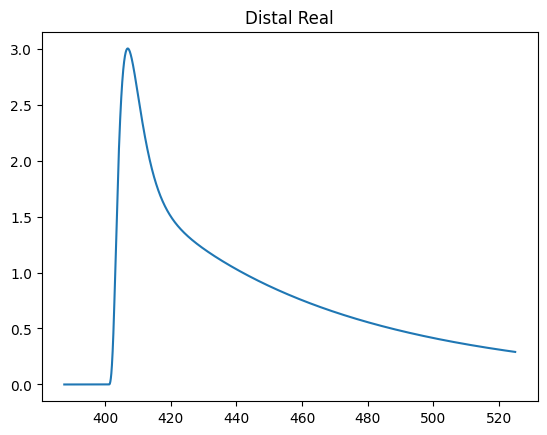

In [511]:
start, end = int(sim_params["event_times"][0][0]/0.025 - 500), int(sim_params["event_times"][0][0]/0.025 + 5000)
real = corrected_v[start:end]
plt.plot(t,real)
plt.title("Distal Real")

#Distal expected

In [504]:
nsyn_exc = int(40 *.04 * 2)
sim_params = {"event_times":[[400], [400.5],[401]],
              "ampa_weight": 0.0001,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.67,
              "ampa_sec": 33,

              "nmda_weight": 0.005,
              "nmda_point_proc": h.NMDAIN,
              "nmda_seg": 0.67,
              "nmda_sec": 33,

              "nsyn_exc":1
              }

In [505]:
h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v= run(h,sim_params)
v = v.as_numpy()

In [506]:
tstart = sim_params["event_times"][0][0]-500
tstop = tstart +50
vrest = np.mean(v[tstart:tstop])
corrected_v = v-vrest
corrected_v = np.array(corrected_v)

Text(0.5, 1.0, 'Distal Expected')

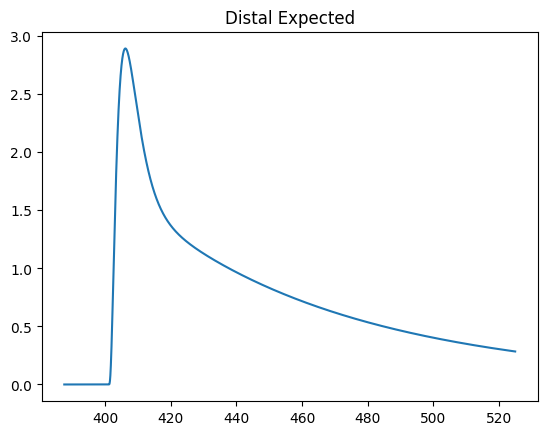

In [507]:
start, end = int(sim_params["event_times"][0][0]/0.025 - 500), int(sim_params["event_times"][0][0]/0.025 + 5000)
expected = corrected_v[start:end] * 3
plt.plot(t,expected)
plt.title("Distal Expected")

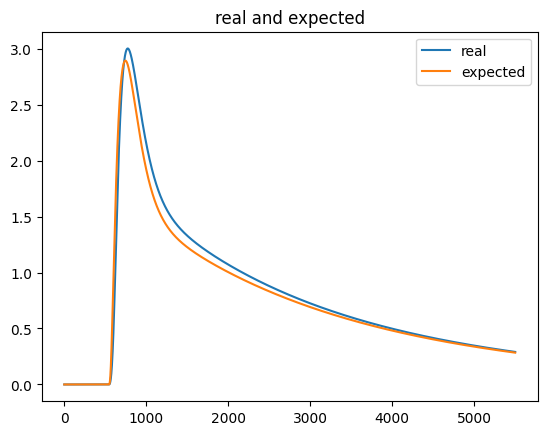

In [512]:
plt.plot(real,label="real")
plt.plot(expected,label="expected")
plt.legend()
plt.title("real and expected")
plt.show()

#distal no nmda

In [609]:
nsyn_exc = int(40 *.04 * 2)
sim_params = {"event_times":[[400], [400.5],[401]],
              "ampa_weight": 0.0002,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.67,
              "ampa_sec": 33,

              "nmda_weight": 0,
              "nmda_point_proc": h.NMDAIN,
              "nmda_seg": 0.67,
              "nmda_sec": 33,

              "nsyn_exc":3
              }

In [610]:
h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v= run(h,sim_params)
v = v.as_numpy()

In [611]:
tstart = sim_params["event_times"][0][0]-500
tstop = tstart +50
vrest = np.mean(v[tstart:tstop])
corrected_v = v-vrest
corrected_v = np.array(corrected_v)

Text(0.5, 1.0, 'Distal real no NMDA')

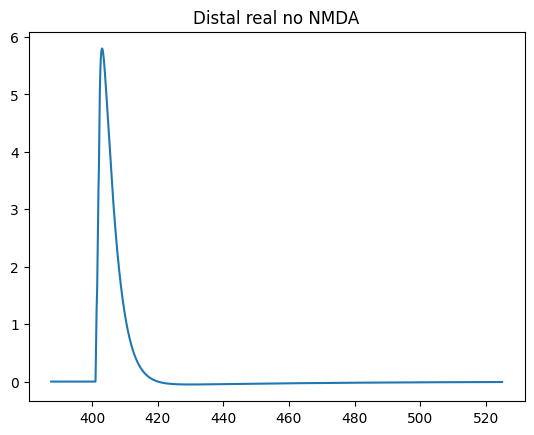

In [612]:
start, end = int(sim_params["event_times"][0][0]/0.025 - 500), int(sim_params["event_times"][0][0]/0.025 + 5000)
real = corrected_v[start:end]
times = np.arange(0,1000.025,0.025)
t = times[start:end]
plt.plot(t,real)
plt.title("Distal real no NMDA")

In [605]:
nsyn_exc = int(40 *.04 * 2)
sim_params = {"event_times":[[400]],
              "ampa_weight": 0.0002,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.67,
              "ampa_sec": 33,

              "nmda_weight": 0,
              "nmda_point_proc": h.NMDAIN,
              "nmda_seg": 0.67,
              "nmda_sec": 33,

              "nsyn_exc":1
              }

In [606]:
h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v= run(h,sim_params)
v = v.as_numpy()

In [607]:
tstart = sim_params["event_times"][0][0]-500
tstop = tstart +50
vrest = np.mean(v[tstart:tstop])
corrected_v = v-vrest
corrected_v = np.array(corrected_v)

Text(0.5, 1.0, 'Distal expected no NMDA')

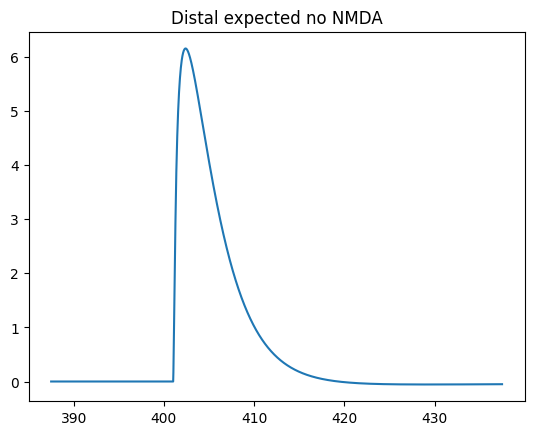

In [608]:
start, end = int(sim_params["event_times"][0][0]/0.025 - 500), int(sim_params["event_times"][0][0]/0.025 + 5000)
expected = corrected_v[start:end] *3
plt.plot(t[:2000],expected[:2000])
plt.title("Distal expected no NMDA")

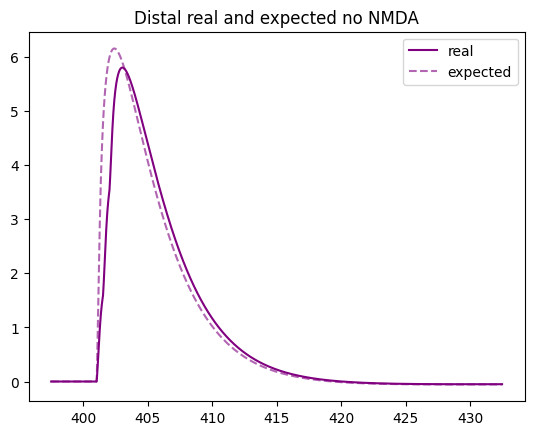

In [613]:
times = np.arange(0,1000.025,0.025)
t = times[start:end]

plt.plot(t[400:1800],real[400:1800],color ="purple", label="real")
plt.plot(t[400:1800],expected[400:1800],color ="purple",linestyle='dashed',label="expected",alpha = 0.6)

plt.legend()
plt.title("Distal real and expected no NMDA")
plt.show()